In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import metrics


In [431]:
! pip install nltk

VADER is a lexicon and rule-based sentiment analysis tool, specific in a Social-media context. 

In [432]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [433]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)
df = df[df['date'] >= '2019-12-01']
df = df.sort_values(by='date')


C:\Users\User\AppData\Local\Temp\ipykernel_7468\3465479924.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [434]:
df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))  


In [435]:
#calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

#aggrergate by day month and year
df['month_date'] = df.date.apply(lambda x: x.month)
df['year_date'] = df.date.apply(lambda x: x.year)
df['daily'] = df.date.apply(lambda x: x.day)
df['week'] = df['date'].dt.isocalendar().week

Groupby values by date and calculate the mean of the sentiment score

In [436]:
freq_d = df.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.mean())
freq_d = freq_d.reset_index()
freq_d = freq_d.rename(columns={0: 'compound'})
num_d = df.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.count())


freq_w = df.groupby(['year_date','month_date','week']).apply(lambda x: x.compound.mean())
freq_w = freq_w.reset_index()
freq_w = freq_w.rename(columns={0: 'compound'})

freq_m = df.groupby(by=['year_date','month_date']).apply(lambda x: x.compound.mean())
freq_m = freq_m.reset_index()
freq_m = freq_m.rename(columns={0: 'compound'})

In [437]:
# drop week first last two weeks unresonable values
freq_w = freq_w.iloc[1:-1]

Df manipulation to plot the timeseries on the same graph

In [438]:
#monthly
freq_m.year_date = freq_m.year_date.astype(str)
freq_m.month_date = freq_m.month_date.astype(str)
freq_m['date'] = freq_m.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date), '%Y-%m'), axis=1)

#daily
freq_d.year_date = freq_d.year_date.astype(str)
freq_d.month_date = freq_d.month_date.astype(str)
freq_d.daily = freq_d.daily.astype(str)
freq_d['date'] = freq_d.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date) + '-' + str(x.daily), '%Y-%m-%d'), axis=1)

#weekly
freq_w.year_date = freq_w.year_date.astype(str)
freq_w.month_date = freq_w.month_date.astype(str)
freq_w.week = freq_w.week.astype(str)
freq_w['date'] = pd.to_datetime(freq_w['year_date'].astype(str) + freq_w['week'].astype(str) + '-1', format='%G%V-%u')

plot the timeseries

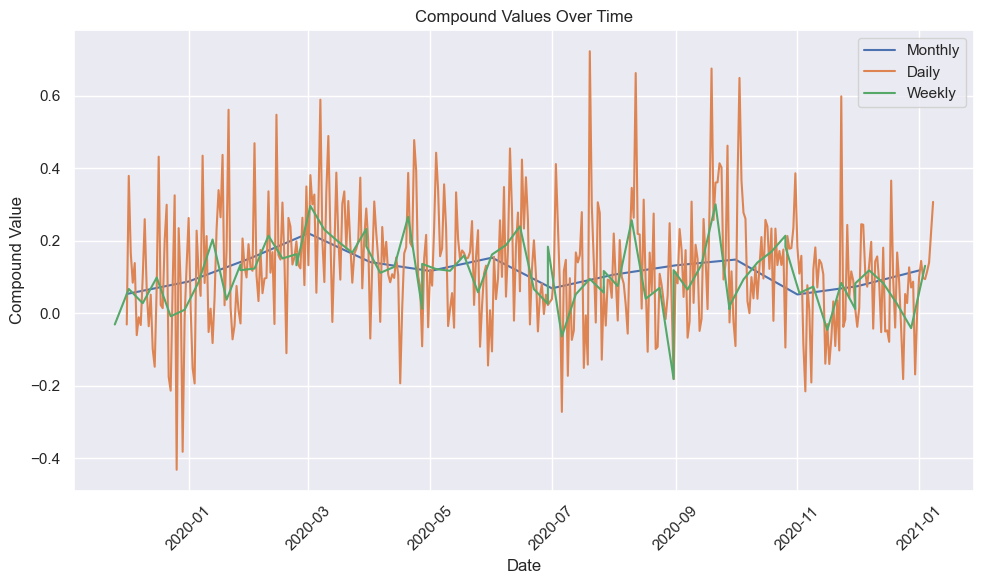

In [439]:
plt.figure(figsize=(10, 6))

# Plotting freq_m
plt.plot(freq_m['date'], freq_m['compound'], label='Monthly' , linestyle='-')

# Plotting freq_d
plt.plot(freq_d['date'], freq_d['compound'], label='Daily', linestyle='-')

# Plotting freq_w
plt.plot(freq_w['date'], freq_w['compound'], label='Weekly', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()


Comments....

From kaggle datset 20 March - 18 April, data from kaggle sentiment among people in US

The Idea is to see if sentiment in population has predictive power on Trump's tweets sentiment.

In [440]:
import os
combined_df = pd.DataFrame()
file_path = 'data'
files = [file for file in os.listdir(file_path)]
# Create a list of DataFrames by reading each CSV file
dataframes = [pd.read_csv(file_path+'/'+file) for file in files]

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
      


In [441]:
combined_df= combined_df.dropna(subset=['text'])

Create column date combining year, month and day

In [442]:
combined_df.user_location.value_counts()
US_df = combined_df[combined_df['user_location']=='United States']
US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D') 

C:\Users\User\AppData\Local\Temp\ipykernel_7468\1456329594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D')


In [443]:
US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))

C:\Users\User\AppData\Local\Temp\ipykernel_7468\3243912476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))


Sentiment analysis with vader

In [444]:
US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])

C:\Users\User\AppData\Local\Temp\ipykernel_7468\2988745508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])


In [445]:
US_df=US_df[US_df['compound']!=0]
US_df_agg = US_df['compound'].groupby(US_df['date']).mean().reset_index()

NOW compare sentiments of people and Trump tweets

In [446]:
#subset old one
start_date = '2020-03-19'
end_date = '2020-04-18'
freq_d_sub = freq_d[(freq_d['date'] >= start_date) & (freq_d['date'] <= end_date)]


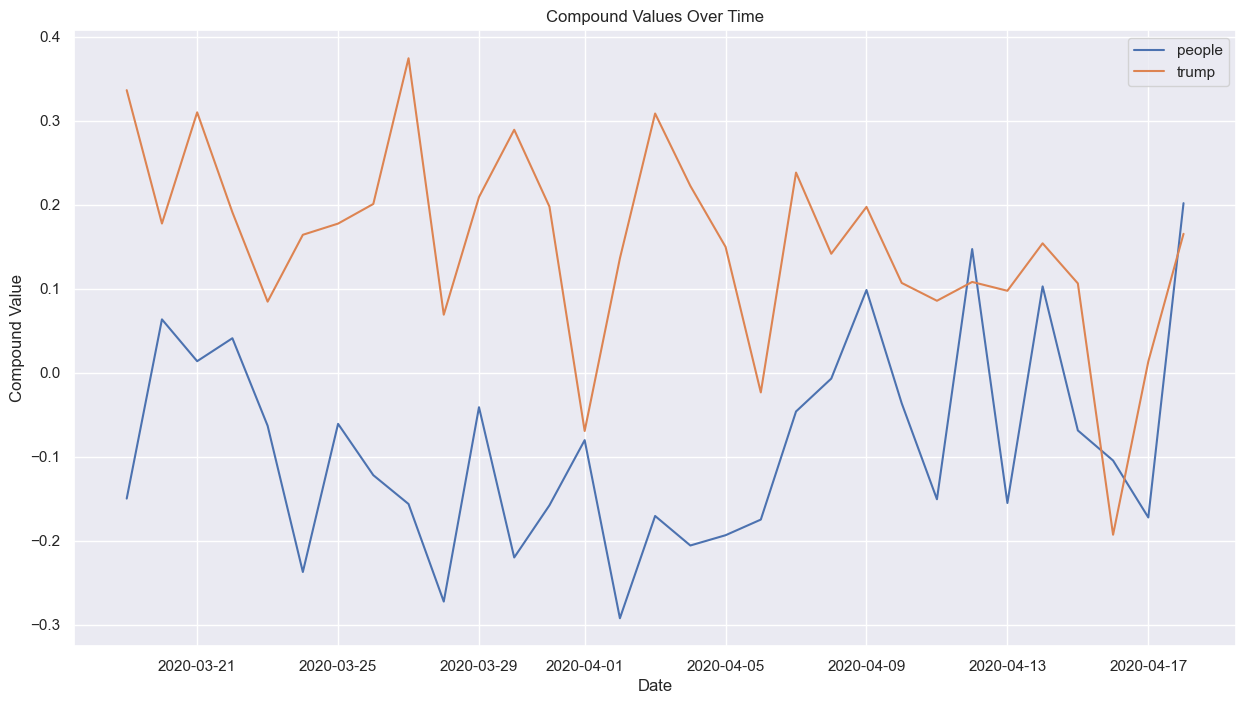

In [447]:
plt.plot(US_df_agg['date'], US_df_agg['compound'], label='people', linestyle='-')
plt.plot(freq_d_sub['date'], freq_d_sub['compound'], label='trump', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()

Comments

Merge people datset and trump dataset the df to do regressions

In [448]:
merged_df = pd.merge(US_df_agg, freq_d_sub, on='date', how='inner')

In [449]:
merged_df.rename(columns={'compound_x': 'people', 'compound_y': 'Trump'}, inplace=True)

In [450]:
merged_df['Trump_sent']= merged_df['Trump'].apply(lambda x: 1 if x>0 else 0 )
merged_df['people_sent']= merged_df['people'].apply(lambda x: 1 if x>0 else 0)

Let's see if there is a correlation between the sentiment of the people about covid and the sentiment of Trump's tweets(all of them)

In [451]:
mod_0 = smf.logit(formula='Trump_sent ~ people_sent ', data=merged_df)
res_0 = mod_0.fit()
print(res_0.summary())

         Current function value: 0.291693
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             Trump_sent   No. Observations:                   31
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.08254
Time:                        17:15:42   Log-Likelihood:                -9.0425
converged:                      False   LL-Null:                       -9.8560
Covariance Type:            nonrobust   LLR p-value:                    0.2021
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9459      0.617      3.153      0.002       0.736       3.156
people_sent    22.9783   9.77e+04      0.000      1.000   -1.9

c:\Users\User\miniconda3\envs\ada\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evidently ther is no way to predict Trump's sentiment based on the sentiment of the people

New Approach -> Even if Covid was the new big thing, Trump's tweets in general do not seems to be correlated with people's sentiment. Let's focus only on the tweets about Covid

In [452]:
# now look at covid tweets
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
df['covid_related'] = df['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

In [453]:
#data where covid_related is true
data_covid_rel = df[df['covid_related']==1]

In [454]:
freq_dc = data_covid_rel.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.mean())
freq_dc = freq_dc.reset_index()
freq_dc = freq_dc.rename(columns={0: 'compound'})

In [455]:
#repeat analysis
freq_dc.year_date = freq_dc.year_date.astype(str)
freq_dc.month_date = freq_dc.month_date.astype(str)
freq_dc.daily = freq_dc.daily.astype(str)
freq_dc['date'] = freq_dc.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date) + '-' + str(x.daily), '%Y-%m-%d'), axis=1)

In [456]:
freq_d_subc = freq_dc[(freq_dc['date'] >= start_date) & (freq_dc['date'] <= end_date)]

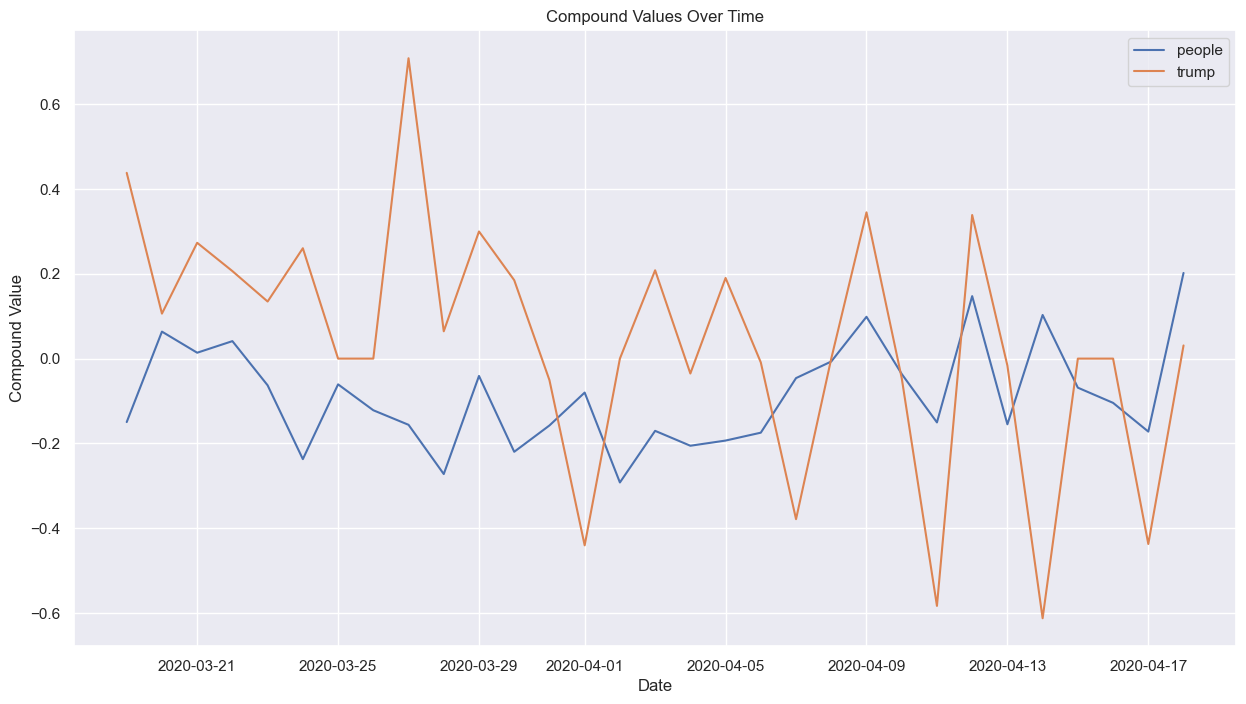

In [457]:
plt.plot(US_df_agg['date'], US_df_agg['compound'], label='people', linestyle='-')
plt.plot(freq_d_subc['date'], freq_d_subc['compound'], label='trump', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()

In [458]:
merged_dfc = pd.merge(US_df_agg, freq_d_subc, on='date', how='inner')

In [459]:
merged_dfc.rename(columns={'compound_x': 'people', 'compound_y': 'Trump'}, inplace=True)

Now we have a dataset with only tweets about covid, let's see if there is a correlation between the sentiment of the people about covid and the sentiment of Trump's tweets(only about covid)

In [460]:
merged_dfc['Trump_sent']= merged_dfc['Trump'].apply(lambda x: 1 if x>0 else 0 )
merged_dfc['people_sent']= merged_dfc['people'].apply(lambda x: 1 if x>0 else 0)

In [461]:
mod_1 = smf.logit(formula='Trump_sent ~ people_sent ', data=merged_dfc)
res_1 = mod_1.fit()
print(res_1.summary())

Optimization terminated successfully.
         Current function value: 0.604785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Trump_sent   No. Observations:                   31
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.1268
Time:                        17:15:43   Log-Likelihood:                -18.748
converged:                       True   LL-Null:                       -21.471
Covariance Type:            nonrobust   LLR p-value:                   0.01961
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5108      0.422     -1.212      0.226      -1.337       0.316
people_sent     2.3026    

We see that the people sentiment variable has a positive correation with Trump's tweet sentiment. It is significative at 5% level, then we have predictive power. 

## FIND NEW VARIABLES

Let's consider a timeseries of new cases of covid in US and see if the variation of the new cases can be used to predict Trump's sentiment tweets the dataset reports the absolute number of new cases, we need to calculate the variation of new cases.

In [462]:
covid = pd.read_csv('timesco/time-series-19-covid-combined.csv')
covid.head()

cov_us = covid[covid['Country/Region']=='US']
sub_cov = cov_us[(cov_us['Date'] >= start_date) & (cov_us['Date'] <= end_date)]

Add the columns with people and Trump sentiment

In [463]:
sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
sub_cov.loc[:,'Trump']= merged_dfc['Trump'].values
sub_cov.loc[:,'people']= merged_dfc['people'].values

C:\Users\User\AppData\Local\Temp\ipykernel_7468\344740220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_7468\344740220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_7468\344740220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Try logistic regression

In [464]:
logit_df = sub_cov.copy()

variation of cases in new cases

In [465]:
logit_df['increase_new_cases'] = logit_df['Confirmed'].shift(1)-logit_df['Confirmed']/logit_df['Confirmed']

In [466]:
logit_df['Confirmed']= (logit_df['Confirmed']-logit_df['Confirmed'].mean())/logit_df['Confirmed'].std()
logit_df['Recovered']= (logit_df['Recovered']-logit_df['Recovered'].mean())/logit_df['Recovered'].std()
logit_df['Deaths']= (logit_df['Deaths']-logit_df['Deaths'].mean())/logit_df['Deaths'].std()
logit_df['increase_new_cases']= (logit_df['increase_new_cases']-logit_df['increase_new_cases'].mean())/logit_df['increase_new_cases'].std()

In [467]:
logit_df.columns

Index(['Date', 'Country/Region', 'Province/State', 'Lat', 'Long', 'Confirmed',
       'Recovered', 'Deaths', 'trump_sent', 'peopl_sent', 'Trump', 'people',
       'increase_new_cases'],
      dtype='object')

In [468]:
mod5 = smf.logit(formula='trump_sent ~ increase_new_cases ', data=logit_df)
res5 = mod5.fit()
print(res5.summary())

Optimization terminated successfully.
         Current function value: 0.603617
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.1264
Time:                        17:15:44   Log-Likelihood:                -18.109
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                   0.02209
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1785      0.404     -0.442      0.658      -0.969       0.612
incre

Let's combine the two models, let's see if the variables keep their predictive power

In [469]:
mod6 = smf.logit(formula='trump_sent ~ peopl_sent + increase_new_cases', data=logit_df)
res6 = mod6.fit()
print(res6.summary())

Optimization terminated successfully.
         Current function value: 0.426899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.3821
Time:                        17:15:44   Log-Likelihood:                -12.807
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 0.0003631
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2070      0.679     -1.777      0.076      -2.538       0.124
peopl

It seems that both variables have predictive power

In [470]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is the variable you want to scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = logit_df['increase_new_cases'].values.reshape(-1, 1)  # If 'data' is a pandas Series
logit_df['scaled_new'] = scaler.fit_transform(scaled)


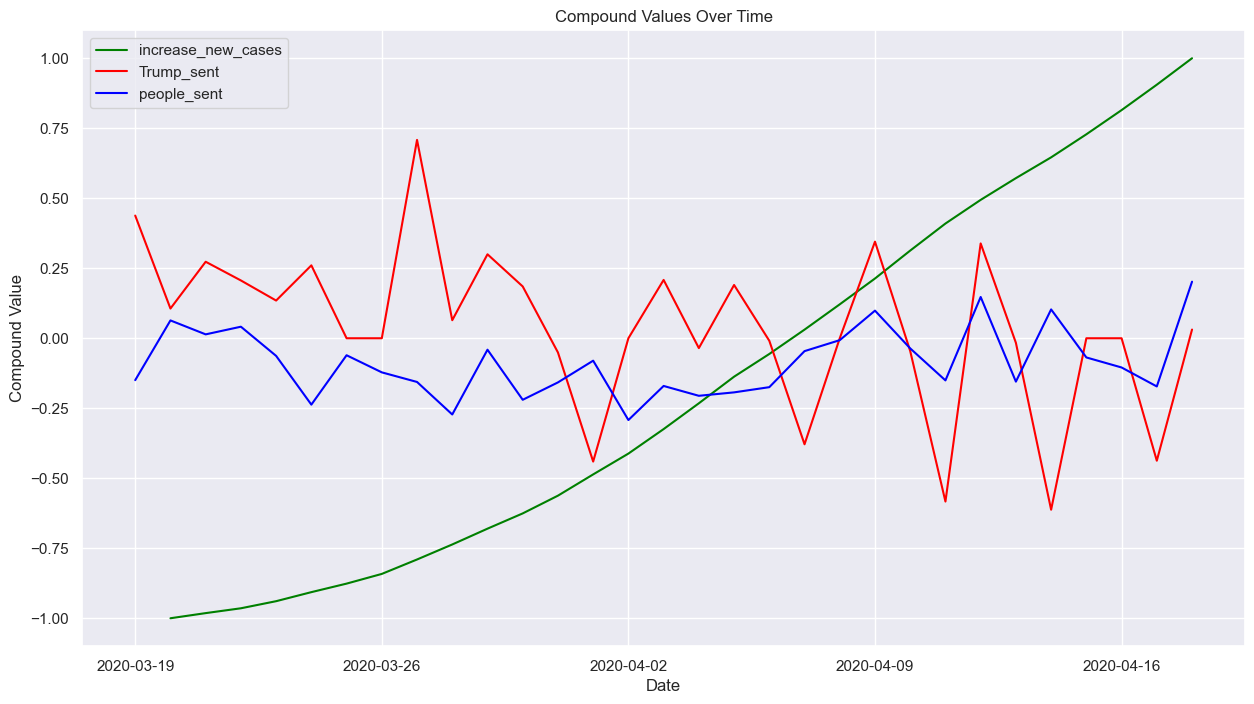

In [471]:
# plots
plt.plot(logit_df['Date'], logit_df['scaled_new'], label='increase_new_cases', linestyle='-',color='green')
plt.plot(logit_df['Date'], logit_df['Trump'], label='Trump_sent', linestyle='-',color='red')
plt.plot(logit_df['Date'], logit_df['people'], label='people_sent', linestyle='-', color='blue')

n = 7 
plt.xticks(logit_df['Date'][::n])
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()


In [472]:
y_pred = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])

In [473]:
y_pred = [ 1 if y>=0.5 else 0 for y in y_pred]

In [474]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(logit_df.trump_sent, y_pred)
print(confusion_matrix)

[[13  3]
 [ 3 12]]


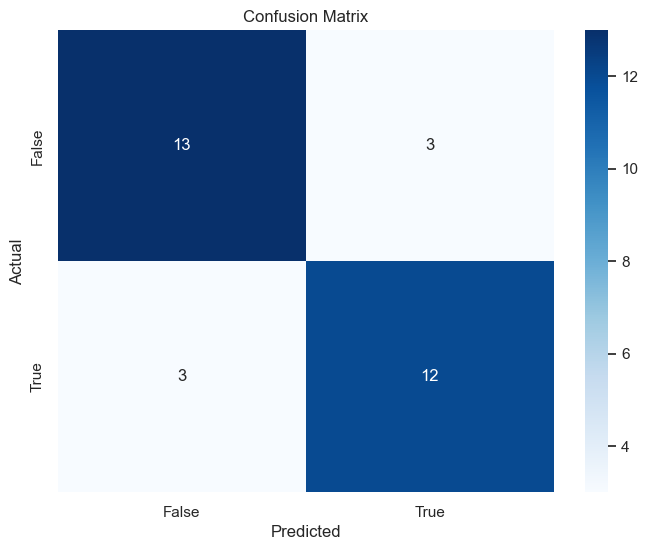

In [475]:
confusion_matrix = metrics.confusion_matrix(logit_df.trump_sent, y_pred)
labels = ['False', 'True']  # Update labels as needed

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [476]:
#fill the miss values given with the mean value
logit_df['increase_new_cases']=logit_df['increase_new_cases'].fillna(logit_df['increase_new_cases'].mean())

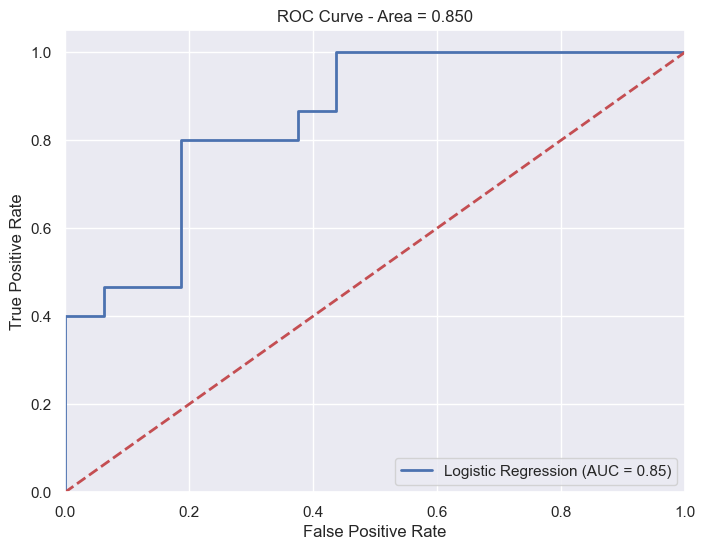

In [477]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
logit_probs = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])

# Calculate ROC curve and AUC
logit_roc_auc = roc_auc_score(logit_df['trump_sent'], logit_probs)
fpr, tpr, thresholds = roc_curve(logit_df['trump_sent'], logit_probs)
auc_score = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc, linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Area = {:.3f}".format(auc_score))
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [478]:
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
f1 = 2*(precision*recall)/(precision+recall)

In [479]:
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))

Precision: 0.800
Recall: 0.800
F1 Score: 0.800
